# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

#### Steps:

Load Input: We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Each pixel is 8 bits ranging from 0 (light) to 255 (dark).

Gaussian Blur: TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.
TODO: explain kernel matrix

Binary Threshold: Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.
TODO: explain OTSU's method

## 1. Import necessary libraries and define constants

Import libraries

In [1]:
import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
from mpl_toolkits.mplot3d import Axes3D # Axes3D for 3D visualization
import numpy as np                 # NumPy for quick maths
from collections import Counter    # dictionary quick maths
from tem_functions import *        # import necessary functions from separate python file
import timeit                      # timing how long it takes to import libraries
from scipy.optimize import fsolve  # used for solving system of nonlin eqs. (particle intersections)
import warnings                    # used for particle intersections
warnings.filterwarnings("ignore", category=RuntimeWarning) # used for particle intersections
import time                        # timing how long it takes to import libraries
from numba import jit, njit, types, typeof  # optimization library
from numba.typed import Dict, List          # optimized data structures


t_pipe_init = time.perf_counter()  # begin timing pipeline

Define constants

In [2]:
# threshold_1 = 55 # for 36a
# threshold_1 = 99 # for 500nm_epoxy_2
# threshold_1 = 70 # for 500nm_epoxy_15
threshold_1 = 55 # for 36a
threshold_2 = 35 # for 36b
threshold_3 = 45 # for 36e
# threshold_1 = 55 # for 36h

print(str(nm_per_pixel), "nm per pixel")
print(str(expected_radius), "nm is expected particle radius")

0.8849557522123894 nm per pixel
100 nm is expected particle radius


## 2. Setup

grayscale, gaussian blur, binary threshold, noise removel, dilation, distance transform

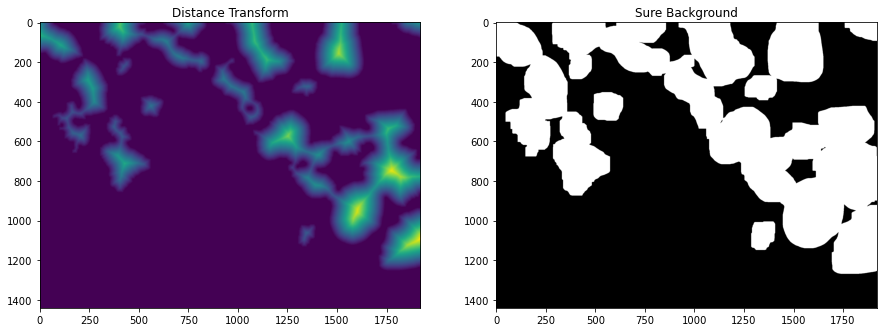

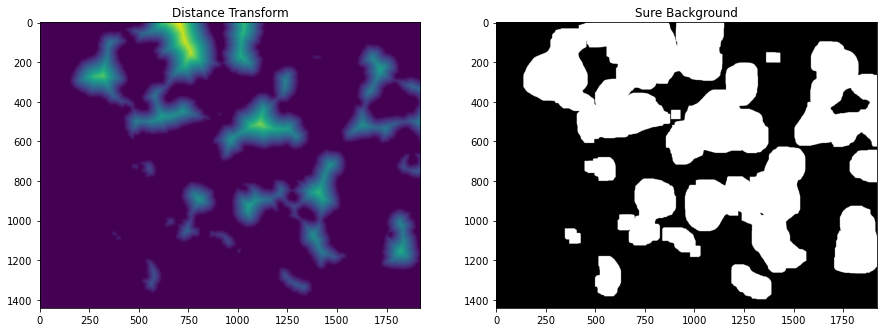

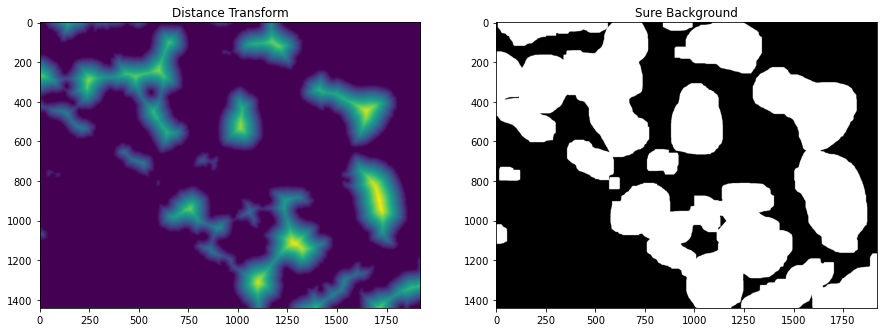

In [3]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

IMAGE_NAME_1 = "./inputs/TES-36a-cropped.tif"
IMAGE_NAME_2 = "./inputs/TES-36b-cropped.tif"
IMAGE_NAME_3 = "./inputs/TES-36e-cropped.tif"
# IMAGE_NAME_1 = "./inputs/TES-36h-cropped.tif"
# IMAGE_NAME_1 = "./inputs/500nm_epoxy/500nm_epoxy_2.jpg"
# IMAGE_NAME_1 = "./inputs/500nm_epoxy/500nm_epoxy_15.jpg"
# IMAGE_NAME_1 = "./inputs/500nm_epoxy/500nm_epoxy_22.jpg"

color_image_1, dist_transform_1, sure_bg_1 = setup(IMAGE_NAME_1, threshold_1, False)
color_image_2, dist_transform_2, sure_bg_2 = setup(IMAGE_NAME_2, threshold_2, False)
color_image_3, dist_transform_3, sure_bg_3 = setup(IMAGE_NAME_3, threshold_3, False)

## 3. Perform watershed and find contours

Find the threshold value that will break up agglomerates into individual particles

In [4]:
dist_transform_thresh_1 = get_watershed_threshold(dist_transform_1, sure_bg_1, color_image_1, expected_radius)
dist_transform_thresh_2 = get_watershed_threshold(dist_transform_2, sure_bg_2, color_image_2, expected_radius)
dist_transform_thresh_3 = get_watershed_threshold(dist_transform_3, sure_bg_3, color_image_3, expected_radius)

Get watershed markers

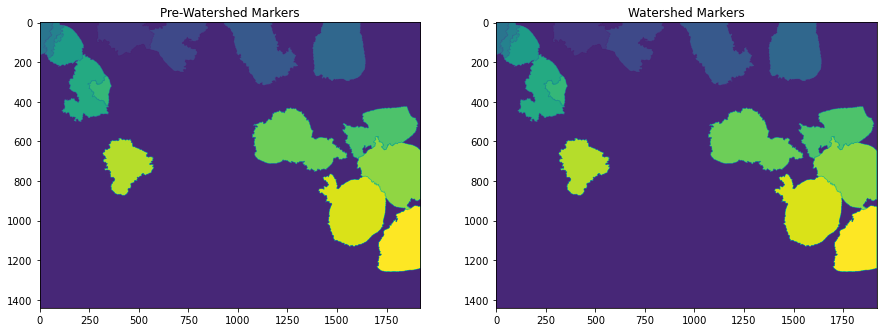

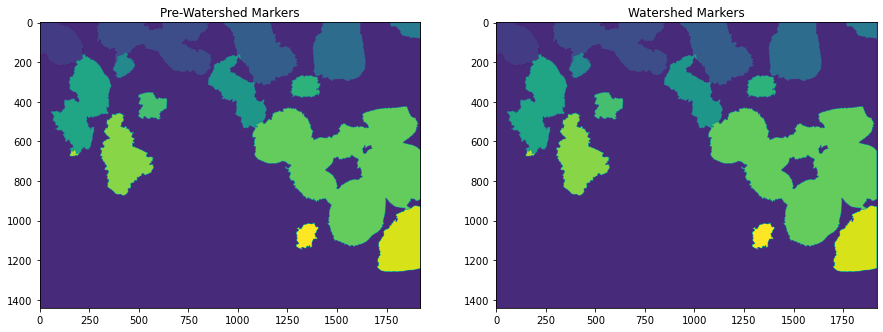

In [5]:
# watershed markers for finding particles (no agglomerates)
watershed_markers_1 = get_watershed_markers(dist_transform_1, dist_transform_thresh_1, sure_bg_1, color_image_1, True)
watershed_markers_2 = get_watershed_markers(dist_transform_2, dist_transform_thresh_2, sure_bg_2, color_image_2, False)
watershed_markers_3 = get_watershed_markers(dist_transform_3, dist_transform_thresh_3, sure_bg_3, color_image_3, False)

# watershed markers for finding agglomerates
agg_watershed_markers_1 = get_watershed_markers(dist_transform_1, 0.1, sure_bg_1, color_image_1, True)
agg_watershed_markers_2 = get_watershed_markers(dist_transform_2, 0.1, sure_bg_2, color_image_2, False)
agg_watershed_markers_3 = get_watershed_markers(dist_transform_3, 0.1, sure_bg_3, color_image_3, False)

Get contours

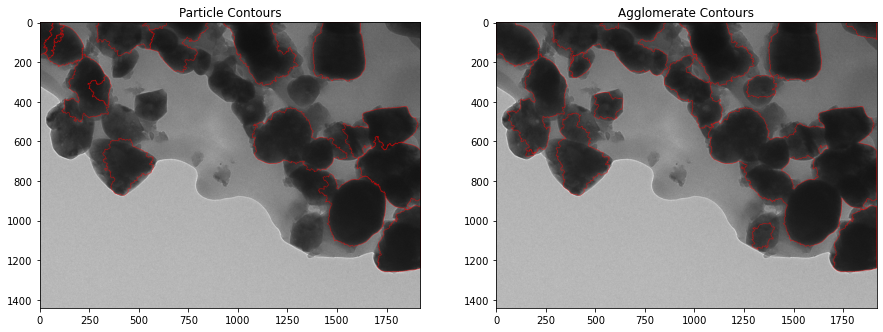

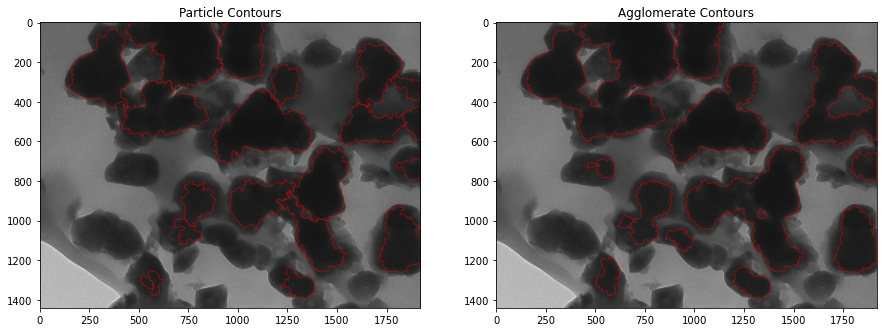

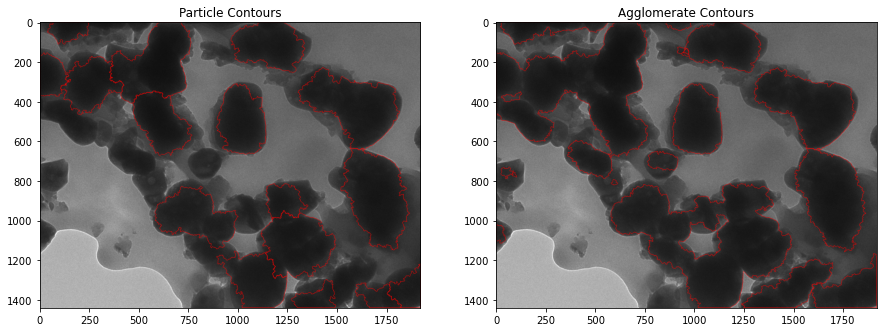

In [6]:
contour_colors_1, chords_color_copy_1 = get_contour_colors(watershed_markers_1, color_image_1)
contour_colors_2, chords_color_copy_2 = get_contour_colors(watershed_markers_2, color_image_2)
contour_colors_3, chords_color_copy_3 = get_contour_colors(watershed_markers_3, color_image_3)

agg_contour_colors_1, agg_chords_color_copy_1 = get_contour_colors(agg_watershed_markers_1, color_image_1)
agg_contour_colors_2, agg_chords_color_copy_2 = get_contour_colors(agg_watershed_markers_2, color_image_2)
agg_contour_colors_3, agg_chords_color_copy_3 = get_contour_colors(agg_watershed_markers_3, color_image_3)

display_images([chords_color_copy_1, agg_chords_color_copy_1], ["Particle Contours", "Agglomerate Contours"], [1, 1])
display_images([chords_color_copy_2, agg_chords_color_copy_2], ["Particle Contours", "Agglomerate Contours"], [1, 1])
display_images([chords_color_copy_3, agg_chords_color_copy_3], ["Particle Contours", "Agglomerate Contours"], [1, 1])

## 4. Finding centerpoints, getting areas, and replacing agglomerates with particles

Finding centerpoints

In [7]:
particles_1 = find_centerpoints(contour_colors_1)
particles_2 = find_centerpoints(contour_colors_2)
particles_3 = find_centerpoints(contour_colors_3)

agg_particles_1 = find_centerpoints(agg_contour_colors_1)
agg_particles_2 = find_centerpoints(agg_contour_colors_2)
agg_particles_3 = find_centerpoints(agg_contour_colors_3)

Getting areas

In [8]:
particle_areas_1 = get_areas(watershed_markers_1)
particle_areas_2 = get_areas(watershed_markers_2)
particle_areas_3 = get_areas(watershed_markers_3)

agg_areas_1 = get_areas(agg_watershed_markers_1)
agg_areas_2 = get_areas(agg_watershed_markers_2)
agg_areas_3 = get_areas(agg_watershed_markers_3)

Replacing agglomerates with particles

In [9]:
# TODO: standardize way of referring to unique particle ID, here particle == color
# TODO: make v2 of function that defines agglomerate area by contour not min/max rectangle

merge_particles_1, merge_contour_colors_1 = match_images(particles_1, contour_colors_1, agg_particles_1, agg_contour_colors_1, agg_areas_1)
merge_particles_2, merge_contour_colors_2 = match_images(particles_2, contour_colors_2, agg_particles_2, agg_contour_colors_2, agg_areas_2)
merge_particles_3, merge_contour_colors_3 = match_images(particles_3, contour_colors_3, agg_particles_3, agg_contour_colors_3, agg_areas_3)
# [print(x, merge_particles[x]) for x in merge_particles.keys()]

## 5. Get long and short chord lengths

Get long chord lengths

In [10]:
long_pairs_1, merge_particles_1, merge_contour_colors_1 = get_long_chord_lengths(merge_particles_1, particles_1, contour_colors_1, merge_contour_colors_1)
long_pairs_2, merge_particles_2, merge_contour_colors_2 = get_long_chord_lengths(merge_particles_2, particles_2, contour_colors_2, merge_contour_colors_2)
long_pairs_3, merge_particles_3, merge_contour_colors_3 = get_long_chord_lengths(merge_particles_3, particles_3, contour_colors_3, merge_contour_colors_3)


In [11]:
print(long_pairs_1)

[[2, (1, 1), (214, 183)], [4, (926, 7), (1299, 220)], [5, (1616, 1), (1390, 271)], [6, (1769, 1), (1918, 88)], [7, (435, 152), (389, 280)], [8, (967, 166), (1093, 529)], [10, (1399, 278), (1270, 371)], [11, (632, 382), (494, 467)], [17, (1904, 510), (1525, 545)], [19, (1692, 578), (1862, 941)], [20, (1427, 781), (1715, 1044)], [13, (397, 458), (425, 872)], [14, (197, 655), (149, 665)], [15, (1918, 928), (1718, 1251)], [16, (1383, 1011), (1292, 1131)], [21, (283, 20), (576, 60)], [22, (846, 4), (552, 136)], [23, (227, 161), (180, 500)], [24, (333, 269), (341, 418)], [25, (1075, 520), (1548, 681)]]


Get short chord lengths

In [12]:
short_pairs_1, merge_particles_1 = get_short_chord_lengths(merge_particles_1, merge_contour_colors_1, long_pairs_1)
short_pairs_2, merge_particles_2 = get_short_chord_lengths(merge_particles_2, merge_contour_colors_2, long_pairs_2)
short_pairs_3, merge_particles_3 = get_short_chord_lengths(merge_particles_3, merge_contour_colors_3, long_pairs_3)

print(merge_particles_1)

{2: [('x', 87.49943038378461), ('y', 106.50273871476355), ('a', 123.96726646383247), ('theta', -139.48743277847583), ('b', 80.71189440828456)], 3: [('x', 513.072440640263), ('y', 95.88169157115915)], 4: [('x', 982.3306783109031), ('y', 136.6318612002067), ('a', 190.05854150044047), ('theta', -150.27166383095857), ('b', 109.84240342749035)], 5: [('x', 1308.1000479831878), ('y', 135.67944801112725), ('a', 155.7974592363028), ('theta', -50.0694201326125), ('b', 134.8512579645084)], 6: [('x', 1634.3179951335183), ('y', 32.96653906358973), ('a', 76.34506657937679), ('theta', -149.71965971749324), ('b', 10.176991150442479)], 7: [('x', 364.45380756439886), ('y', 191.7070627360352), ('a', 60.18349782626302), ('theta', -70.23283132320836), ('b', 39.85740893765857)], 9: [('x', 170.2333978683352), ('y', 376.9626791181259)], 8: [('x', 873.3272361127214), ('y', 301.4242592091647), ('a', 170.02036059449182), ('theta', -109.14226819146627), ('b', 76.49878163415866)], 10: [('x', 1179.7277222469813), (

Display chord lengths

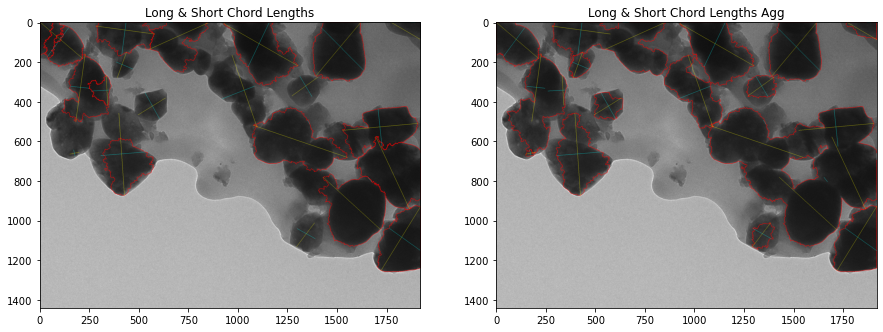

In [13]:
# draw_long_lengths(chords_color_copy, long_pairs)
# draw_short_lengths(chords_color_copy, short_pairs)
# display_images([chords_color_copy], ["Long & Short Chord Lengths"], [0])
# plt.savefig("chords_color_copy_long_short_chord_lengths.png", dpi=500)

# draw_long_lengths(chords_color_copy_1, long_pairs_1)
# draw_long_lengths(chords_color_copy_2, long_pairs_2)
# draw_long_lengths(chords_color_copy_3, long_pairs_3)

# draw_long_lengths(agg_chords_color_copy_1, long_pairs_1)
# draw_long_lengths(agg_chords_color_copy_2, long_pairs_2)
# draw_long_lengths(agg_chords_color_copy_3, long_pairs_3)

# draw_short_lengths(chords_color_copy_1, short_pairs_1)
# draw_short_lengths(chords_color_copy_2, short_pairs_2)
# draw_short_lengths(chords_color_copy_3, short_pairs_3)

# draw_short_lengths(agg_chords_color_copy_1, short_pairs_1)
# draw_short_lengths(agg_chords_color_copy_2, short_pairs_2)
# draw_short_lengths(agg_chords_color_copy_3, short_pairs_3)

# display_images([chords_color_copy_1, agg_chords_color_copy_1], ["Long & Short Chord Lengths", "Long & Short Chord Lengths Agg"], [0, 0])
# plt.savefig("500nm_epoxy_15_chord_lengths.png", dpi=500)

# draw_long_lengths(agg_chords_color_copy, long_pairs)
# draw_short_lengths(agg_chords_color_copy, short_pairs)
# display_images([agg_chords_color_copy], ["Agg Long & Short Chord Lengths"], [0])
# plt.savefig("./visualizations/36b_troubleshooting.png", dpi=500)

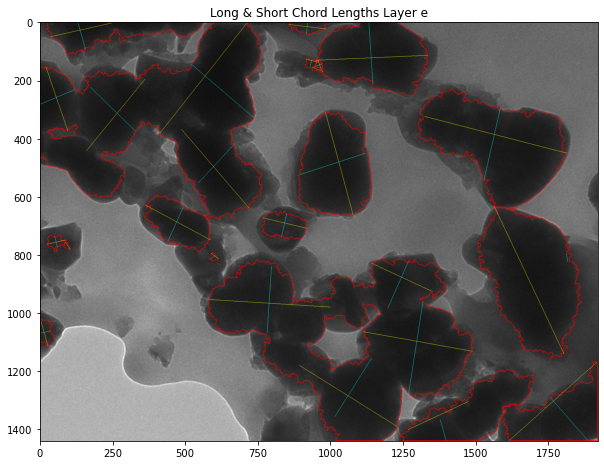

In [14]:
# display_images([chords_color_copy_1], ["Long & Short Chord Lengths Layer a"], [0])
# display_images([chords_color_copy_2], ["Long & Short Chord Lengths Layer b"], [0])
# display_images([chords_color_copy_3], ["Long & Short Chord Lengths Layer e"], [0])

# display_images([agg_chords_color_copy_3], ["Long & Short Chord Lengths Layer e"], [0])

# plt.savefig("long_short_chord_lengths_e.png", dpi=500)

## 6. Get c radii and layer information

In [15]:
merge_particles_1 = get_c(merge_particles_1)
merge_particles_2 = get_c(merge_particles_2)
merge_particles_3 = get_c(merge_particles_3)

# merge_particles_1 = set_max_c(merge_particles_1)
# merge_particles_2 = set_max_c(merge_particles_2)
# merge_particles_3 = set_max_c(merge_particles_3)

# print(merge_particles_1)

In [16]:
intersections = layer_check_intersections(merge_particles_1)
print(intersections)

[[4, 8], [5, 10], [7, 21], [8, 18], [8, 25], [17, 19], [23, 24]]


In [17]:
# merge_particles_1 = layer_xy_rotate_particles(merge_particles_1)
# intersections = layer_check_intersections(merge_particles_1)
# print(intersections)
merge_particles_1 = layer_scale_particles(merge_particles_1)
merge_particles_2 = layer_scale_particles(merge_particles_2)
merge_particles_3 = layer_scale_particles(merge_particles_3)
# intersections = layer_check_intersections(merge_particles_1)
# print(intersections)

In [18]:
info_1 = get_layer_info(merge_particles_1)
info_2 = get_layer_info(merge_particles_2)
info_3 = get_layer_info(merge_particles_3)

# print(info_1)
# print(info_2)
# print(info_3)

## 7. Render layer

In [19]:
# %matplotlib notebook

# layer_render(merge_particles_1, info_1)

## 8. Combine layers and save to a text file

In [20]:
# combine_layers([merge_particles_1,merge_particles_2,merge_particles_3], [info_1, info_2, info_3], "./outputs/18_02_21_scaled_50nm_offset_abe.txt")
# combine_layers([merge_particles_1,merge_particles_3,merge_particles_2], [info_1, info_3, info_2], "./outputs/18_02_21_scaled_50nm_offset_aeb.txt")
# combine_layers([merge_particles_2,merge_particles_1,merge_particles_3], [info_2, info_1, info_3], "./outputs/18_02_21_scaled_50nm_offset_bae.txt")
# combine_layers([merge_particles_2,merge_particles_3,merge_particles_1], [info_2, info_3, info_1], "./outputs/18_02_21_scaled_50nm_offset_bea.txt")
# combine_layers([merge_particles_3,merge_particles_1,merge_particles_2], [info_3, info_1, info_2], "./outputs/18_02_21_scaled_50nm_offset_eab.txt")
# combine_layers([merge_particles_3,merge_particles_2,merge_particles_1], [info_3, info_2, info_1], "./outputs/18_02_21_scaled_50nm_offset_eba.txt")



In [21]:
# combine_layers([merge_particles_2,merge_particles_3], [info_2, info_3], "two_layer_be.txt")

In [22]:
# combine_layers([merge_particles_1], [info_1], "./outputs/18_02_21_scaled_50nm_offset_a.txt")
# combine_layers([merge_particles_2], [info_2], "./outputs/18_02_21_scaled_50nm_offset_b.txt")
# combine_layers([merge_particles_3], [info_3], "./outputs/18_02_21_scaled_50nm_offset_e.txt")

In [23]:
t_pipe_final = time.perf_counter()

print("time to run pipeline:", str(t_pipe_final - t_pipe_init), "seconds")

time to run pipeline: 67.99176149400228 seconds
